# Tutorial: Validating low-frequency somatic mutations with UMI-tagged smMIPs 

Here, we will use data from an experiment described in [Selfish mutations dysregulating RAS-MAPK signaling are pervasive in aged human testes](https://www.biorxiv.org/content/early/2018/05/04/314815).
In this work, Maher et al conducted a screen for somatic mutations in testes, searching for mutations observed at very low frequencies (<5%).
Due to the technical challenges inherent in calling mutations at such low frequencies, possible hits needed to be validated with a separate method.

To perform this validation, Maher et al resequenced regions around observed mutations using single-molecule molecular inversion probes (smMIPs). Each smMIP was tagged with unique molecular identifiers (UMIs), enabling accurate quantification of variant allele frequencies (VAFs).

Here, we will look at how amplimap can process data from such an experiment and generate VAFs for specific mutations.

## Analysis overview

Starting from the raw sequencing reads, we would like to:

- Trim off UMIs and primer sequences
- Align reads to the reference genome
- Group reads with the same UMI together and determine a consensus call for each nucleotide
- Pile up reads in the target regions and count how often we observed each nucleotide at each position
- Compare the observed nucleotide counts to our expectation

## Running amplimap
First, we need to prepare our working directory with the input data:

    ...

Then, we can run amplimap using the ``pileups`` target:

    amplimap pileups --run

This will take a few minutes to complete. It would be much faster if we
ran jobs in parallel (for example using the cluster), but we are not
doing that for the purposes of this tutorial.

## Analysing the results

amplimap has now processed our reads, aligned them to the reference genome and calculated read counts for each site and each sample.

Since we told it that our reads contained UMIs, amplimap has also grouped all raw reads sharing the same UMI into UMI groups.
For each UMI group and each position, amplimap has determined a consensus call, which reflects the most commonly observed call among all reads in the UMI group.
This way, biases due to DNA amplification duplicates and random sequencing errors have been minimized, resulting in highly accurate VAFs.

Finally, amplimap generated a pileup table from these UMI groups, telling us how many UMI groups support a given call at each basepair of the target region.
There is one pileup table for each individual sample, as well as several summary tables that contain all of the samples aggregated together.

We will use these tables to look for the mutations we wanted to validate. In this tutorial, we will use Python and pandas for this, but the same thing could be done in R, or by just filtering the tables in Excel.

Based on previous work, we expected to find the following mutations:

- A ``G>C`` mutation at 123276865 in samples 4C22 (at approx. 0.13%) and 4C23 (0.24%)
- An ``A>T`` mutation at 123276893 in samples 14D29 (at approx. 2.95%) and 14D7 (0.33%).

The 979-blood sample acts as a negative control which should not show any mutations. Thus, the VAF we observe in this sample gives us an idea about the error rate we can expect.

All the information we need to check this is contained in the ``pileups_long_detailed.csv`` summary table, and in particular in the ``number_called_hq`` and ``count_hq_A/C/G/T`` columns. Here, the ``_hq`` denotes that the calls were filtered by base quality, with the minimum threshold being set to 30 by default.

In [1]:
import pandas as pd
d = pd.read_csv('analysis/pileup/pileups_long_detailed.csv')

d.loc[
    d.pos.isin([123276865, 123276893]),
    ['sample', 'chr', 'pos', 'ref', 'number_called_hq', 'nonref_hq_count_fraction', 'count_hq_A', 'count_hq_C', 'count_hq_G', 'count_hq_T']
].sort_values(['pos', 'sample'])

,sample,chr,pos,ref,number_called_hq,nonref_hq_count_fraction,count_hq_A,count_hq_C,count_hq_G,count_hq_T
65,14D29-combined_S01,chr10,123276865,G,13935,0.000072,1,0,13934,0
237,14D7-combined_S01,chr10,123276865,G,12888,0.000155,2,0,12886,0
409,4C22-combined_S01,chr10,123276865,G,12749,0.001412,3,15,12731,0
581,4C23-combined_S01,chr10,123276865,G,12924,0.001470,2,17,12905,0
753,979-blood-combined_S01,chr10,123276865,G,13649,0.000073,0,0,13648,1
93,14D29-combined_S01,chr10,123276893,A,13916,0.030181,13496,0,1,419
265,14D7-combined_S01,chr10,123276893,A,12890,0.003258,12848,0,2,40
437,4C22-combined_S01,chr10,123276893,A,12757,0.000157,12755,0,2,0
609,4C23-combined_S01,chr10,123276893,A,12931,0.000077,12930,0,1,0
781,979-blood-combined_S01,chr10,123276893,A,13650,0.000513,13643,0,6,1


The first thing we see is that we thoroughly covered both sites, with around 13,000 unique UMIs observed in all five samples.
The vast majority of these UMI groups supported the reference allele, agreeing with our expectation that any potential mutations would be observed at very low frequencies.
The background frequency of errorneous non-reference calls also seems to be low, with ``nonref_hq_count_fraction`` at 0.007% and 0.05% for the blood control.

Looking at samples 4C22 and 4C23 we see a non-reference call rate (``nonref_hq_count_fraction``) above the background at position 123276865 but only a low rate at position 123276893, as expected. The observed VAF for the G>C mutation at 123276865 was 15 / 12749 = 0.12% and 17 / 12924 = 0.13%. The former of these is exactly as high as expected, while the latter is a bit lower. However, a small mismatch here is not surprising given the inaccuracies involved in VAF quantification during the previous screen.

Similarly, samples 14D29 and 14D7 show a non-reference call rate much higher than the background at 123276893 but low at 123276865. The VAFs for the A>T mutation are 419 / 13916 = 3.0% and 40 / 12890 = 0.31%, very close to the VAFs we expected to see.

If we wanted to look at the counts for a specific sample in more detail, we could have a look at the per-sample pileup files. For example, here is all the available data for the mutation site in 14D29:

In [2]:
d = pd.read_csv('analysis/pileup/14D29-combined_S01.pileup.csv')
d.loc[d.pos == 123276893].iloc[0]

chr                                                                            chr10
pos                                                                        123276893
target_id                                                                FGFR2_C342A
target_type                                                                   target
ref                                                                                A
alts                                                                             G;T
raw_coverage                                                                  133357
umi_groups                                                                     16511
unique_raw_umis                                                                24551
unique_mate_starts                                                                 1
group_below_min                                                                 2580
group_no_majority                                                

There is a lot of additional information here that may be helpful to understand the underlying data. For example we can see that this site was covered by two probes. Between them, we had 133357 read pairs covering this site (``raw_coverage``) which belonged to 16511 UMI groups (``umi_groups``). Of these, 2580 UMI groups didn't have at least two supporting reads (``groups_below_min``), so they were filtered out.

The mean base call quality score was close to 39 for both nucleotides (``phred_A``, ``phred_T``), suggesting that it is very unlikely that they were due to a sequencing error. The high quality of the data is further confirmed by the fact that the nucleotide counts not filtered for base quality (``count_A/C/G/T``) are actually the same as the quality-filtered ones (``count_hq_A/C/G/T``), telling us that not a single UMI group had a phred score of < 20 at this site. Maybe we could consider setting an even stricter threshold to remove the few errorneous reads we observed in the blood sample.

## Identifying new low-frequency mutations [will probably not include this]

In addition to looking for expected mutations, we could also use this data to look for new ones. A very basic approach to this could be to look for sites where we observed VAFs far above the background levels in one of the samples.

To estimate the background level, we will simply use the non-reference allele fraction of the blood sample. If we had more samples, we might be able to use something more sophisticated here, for example considering the median non-reference fraction and its variance across all samples to build a better estimate of the expected background.

Let's look at the non-reference fraction in the blood sample across the entire targeted region:

In [26]:
%matplotlib inline

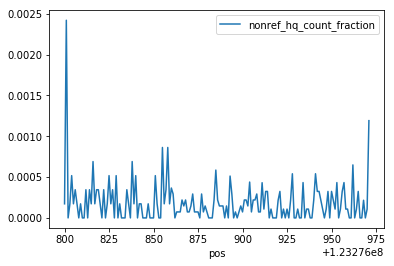

In [27]:
d = pd.read_csv('analysis/pileup/pileups_long_detailed.csv')
d.loc[d['sample'] == '979-blood-combined_S01', ['pos', 'nonref_hq_count_fraction']].set_index(['pos']).plot()

It looks like the background stays below 0.1% for almost the entire targeted region, although it does go up towards the ends.

Finally, we can look for sites above this level, using an arbitrary threshold of $(background + 0.1\%)$:

In [32]:
data_with_background = d[d['sample'] != '979-blood-combined_S01'].merge(
    d.loc[d['sample'] == '979-blood-combined_S01', ['chr', 'pos', 'nonref_hq_count_fraction']].rename(
        columns = {'nonref_hq_count_fraction': 'background_fraction'}
    ),
    on = ['chr', 'pos']
)
data_with_background['threshold'] = (data_with_background['background_fraction'] + 1e-3)

data_with_background.loc[
    data_with_background['nonref_hq_count_fraction'] > data_with_background['threshold'],
    ['sample', 'chr', 'pos', 'ref', 'number_called_hq', 'nonref_hq_count_fraction', 'count_hq_A', 'count_hq_C', 'count_hq_G', 'count_hq_T', 'background_fraction']
]

,sample,chr,pos,ref,number_called_hq,nonref_hq_count_fraction,count_hq_A,count_hq_C,count_hq_G,count_hq_T,background_fraction
6,4C22-combined_S01,chr10,123276801,A,5931,0.007587,5886,0,45,0,0.002421
7,4C23-combined_S01,chr10,123276801,A,6081,0.008716,6028,0,53,0,0.002421
262,4C22-combined_S01,chr10,123276865,G,12749,0.001412,3,15,12731,0,0.000073
263,4C23-combined_S01,chr10,123276865,G,12924,0.001470,2,17,12905,0,0.000073
372,14D29-combined_S01,chr10,123276893,A,13916,0.030181,13496,0,1,419,0.000513
373,14D7-combined_S01,chr10,123276893,A,12890,0.003258,12848,0,2,40,0.000513


In this case, we recovered the two mutations we were expecting to find, plus a third one at position 123276801 with a VAF of 0.76%/0.87% in samples 4C22 and 4C23. However, this is actually the site with the highest background level in the entire region (0.24%), so we would be extremely sceptical about this site and should probably discard it as a technical artefact.